#### 3DCORE ABC SMC fitting for Nov 2020 and June 2020 events

output in /results/abc_runs

install from git

https://github.com/ajefweiss/py3DCORE

https://github.com/ajefweiss/HelioSat


TO DO:
- transform frame -> measure function output in RTN
- fit parameter mit error bars
- measure function -> ensembles plotten


In [47]:
import datetime
import heliosat
import logging

import numpy as np
import os
import pickle
import py3dcore

from heliosat.util import configure_logging
from py3dcore.fitter import ABC_SMC

from matplotlib import pyplot as plt

configure_logging(debug=False, logfile=None, verbose=True)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

print(py3dcore.__version__)
print(heliosat.__version__)

2.0.1
0.6.0


## 2020 Nov 29 CME

In [63]:
dt_0 = datetime.datetime(2020, 11, 29, 15, tzinfo=datetime.timezone.utc)

t_s = datetime.datetime(2020, 12, 1, tzinfo=datetime.timezone.utc)
t_e = datetime.datetime(2020, 12, 1, 10, tzinfo=datetime.timezone.utc)

t_fp = [
    datetime.datetime(2020, 12, 1, 3, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2020, 12, 1, 4, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2020, 12, 1, 5, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2020, 12, 1, 6, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2020, 12, 1, 7, 30, tzinfo=datetime.timezone.utc),
]

model_kwargs = {
    "ensemble_size": int(2**18),
    "iparams": {
        "cme_longitude": {
            "maximum": 0,
            "minimum": -120
        },
        "cme_inclination": {
            "maximum": 360,
            "minimum": 180
        }, 
        "cme_launch_velocity": {
            "maximum": 2000,
            "minimum": 800
        },
        "t_factor": {
            "maximum": 120,
            "minimum": 0
        }
    }
}

fitter = ABC_SMC()
fitter.initialize(dt_0, py3dcore.ToroidalModel, model_kwargs)
fitter.add_observer("PSP", t_fp, t_s, t_e)

#possible to add 2nd observer here
a = heliosat.PSP()

In [50]:
fitter.run(5, 512, reference_frame="HCI", jobs=32, workers=32, sampling_freq=3600, output="/home/cmoestl/pycode/solar_orbiter/fits/2020nov29")

2021-08-30 13:00:12,481 - py3dcore.fitter.abc_smc - running iteration 0
2021-08-30 13:00:12,481 - py3dcore.fitter.abc_smc - running iteration 0
2021-08-30 13:00:12,485 - py3dcore.fitter.abc_smc - initial eps_init = [1.16611912]
2021-08-30 13:00:12,485 - py3dcore.fitter.abc_smc - initial eps_init = [1.16611912]
2021-08-30 13:01:12,346 - py3dcore.fitter.abc_smc - step 0:0 with (1202/512) particles
2021-08-30 13:01:12,346 - py3dcore.fitter.abc_smc - step 0:0 with (1202/512) particles
2021-08-30 13:01:12,349 - py3dcore.fitter.abc_smc - setting new eps: [1.16611912] => [0.87994014]
2021-08-30 13:01:12,349 - py3dcore.fitter.abc_smc - setting new eps: [1.16611912] => [0.87994014]
2021-08-30 13:01:12,350 - py3dcore.fitter.abc_smc - step 0 done, 512 particles, 8.39M runs in 59.87 seconds, (total: 00h 00m 59s)
2021-08-30 13:01:12,350 - py3dcore.fitter.abc_smc - step 0 done, 512 particles, 8.39M runs in 59.87 seconds, (total: 00h 00m 59s)
2021-08-30 13:01:12,380 - py3dcore.fitter.abc_smc - runnin

In [51]:
fit11=pickle.load(open('fits/2020nov29/11.pickle', "rb" ) )

In [52]:
fit=fit11#['model_obj']

print(fit.keys())
print()

print(fit['model_obj'].__dict__.keys())

print()
print(fit['model_obj'].iparams.keys())

print()
best_fit_ind=np.argmin(fit['hist_eps'])
print(best_fit_ind)



dict_keys(['locked', 'dt_0', 'model_kwargs', 'observers', 'model', 'iter_i', 'hist_eps', 'hist_time', 'hist_eps_dim', 'model_obj', 'data_obj', 'epses'])

dict_keys(['dt_0', 'dt_t', 'iparams', 'sparams', 'ensemble_size', 'dtype', 'iparams_arr', 'iparams_kernel', 'iparams_weight', 'iparams_kernel_decomp', 'sparams_arr', 'qs_sx', 'qs_xs', 'iparams_meta', 'mag_model', 'shape_model'])

dict_keys(['cme_launch_offset', 'cme_longitude', 'cme_latitude', 'cme_inclination', 'cme_diameter_1au', 'cme_aspect_ratio', 'cme_launch_radius', 'cme_launch_velocity', 't_factor', 'cme_expansion_rate', 'magnetic_decay_rate', 'magnetic_field_strength_1au', 'background_drag', 'background_velocity'])

6


In [53]:
model=fit['model'](fit['dt_0'],1)


parr=fit['model_obj'].iparams_arr

model.update_iparams(parr[best_fit_ind].reshape(1,-1))

t_launch=fit['dt_0']

TP_A =  t_launch + datetime.timedelta(hours=24)
print(TP_A)

2020-11-30 15:00:00+00:00


In [54]:
print('model parameters')

params=['cme_launch_offset', 'cme_longitude', 'cme_latitude', 'cme_inclination', 'cme_diameter_1au', 'cme_aspect_ratio', 'cme_launch_radius', 'cme_launch_velocity', 't_factor', 'cme_expansion_rate', 'magnetic_decay_rate', 'magnetic_field_strength_1au', 'background_drag', 'background_velocity']

print(model.iparams_arr)

print(params)

model parameters
[[ 0.00000000e+00 -1.00835724e+02  9.55759048e+00  2.65671387e+02
   8.08468014e-02  2.91288877e+00  2.00000000e+01  1.67035303e+03
   6.98396378e+01  1.13999999e+00  1.63999999e+00  2.81599293e+01
   3.37259442e-01  3.87128754e+02]]
['cme_launch_offset', 'cme_longitude', 'cme_latitude', 'cme_inclination', 'cme_diameter_1au', 'cme_aspect_ratio', 'cme_launch_radius', 'cme_launch_velocity', 't_factor', 'cme_expansion_rate', 'magnetic_decay_rate', 'magnetic_field_strength_1au', 'background_drag', 'background_velocity']


In [55]:
def measure(obj, sat, t0, t1, frame="HEEQ", bframe="HEEQ", satparams=None):
    
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    #time resolution in seconds
    print('t0',t0)
    
    #t_s1 = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    #print('t_s1',t_s1[0],t_s1[-1])
    
    #time resolution in minutes as fraction per day
    res_in_days=1/(60.)    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += datetime.timedelta(days=res_in_days)
        
    print('t_s',t_s[0],t_s[-1])    
    print()
    
    o_s = inst.trajectory(t_s, reference_frame=frame)

    #b = 
    #print(len(t_s), b.shape)

    b = heliosat.transform.transform_reference_frame(t_s, np.array(obj.simulator(t_s, o_s)[0]).reshape(-1, 3), frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b

In [65]:
t2, btot2, bxyz2 = measure(model, "PSP", t_launch, t_launch  + datetime.timedelta(hours=96), frame="HCI", bframe="SPP_RTN")

t0 2020-11-29 15:00:00+00:00
t_s 2020-11-29 15:00:00+00:00 2020-12-03 14:36:00+00:00



In [94]:
ensemble_data = py3dcore.fitter.generate_ensemble('fits/2020nov29/11.pickle', t2, reference_frame="SPP_RTN", max_index=64, perc=0.66)

/home/aweiss/code/git/py3DCORE/py3dcore/fitter/base.py:40: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/aweiss/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/aweiss/code/git/py3DCORE/py3dcore/fitter/base.py:46: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


In [95]:
sta_ensemble = ensemble_data[0]

(_, _, (psp_b_s2p, psp_b_s2n), (psp_b_ts2p, psp_b_ts2n)) = sta_ensemble

In [67]:
print('load PSP data SCEQ') #from heliosat, converted to SCEQ similar to STEREO-A/B
data_path='/nas/helio/data/insitu_python/'
filepsp='psp_2018_2021_rtn.p'
[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 


load PSP data SCEQ


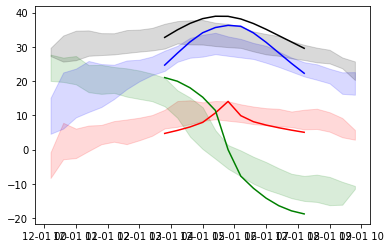

In [96]:
plt.plot(t2,bxyz2[:,0],'r')
plt.plot(t2,bxyz2[:,1],'g')
plt.plot(t2,bxyz2[:,2],'b')

plt.plot(t2,btot2,'k')

plt.fill_between(t2, psp_b_s2p[:, 0], psp_b_s2n[:, 0], color="r", alpha=0.15)
plt.fill_between(t2, psp_b_s2p[:, 1], psp_b_s2n[:, 1], color="g", alpha=0.15)
plt.fill_between(t2, psp_b_s2p[:, 2], psp_b_s2n[:, 2], color="b", alpha=0.15)

plt.fill_between(t2, psp_b_ts2p, psp_b_ts2n, color="k", alpha=0.15)

(-35.0, 35.0)

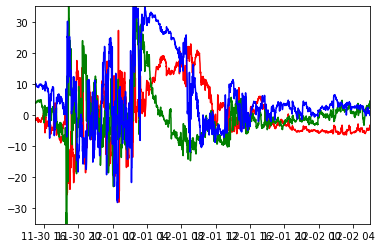

In [69]:
plt.plot(psp.time,psp.bx,'r')
plt.plot(psp.time,psp.by,'g')
plt.plot(psp.time,psp.bz,'b')
plotstart=datetime.datetime(2020,11,30,15)
plotend=datetime.datetime(2020,12,2,6)
plt.xlim(plotstart,plotend)
plt.ylim([-35, 35])

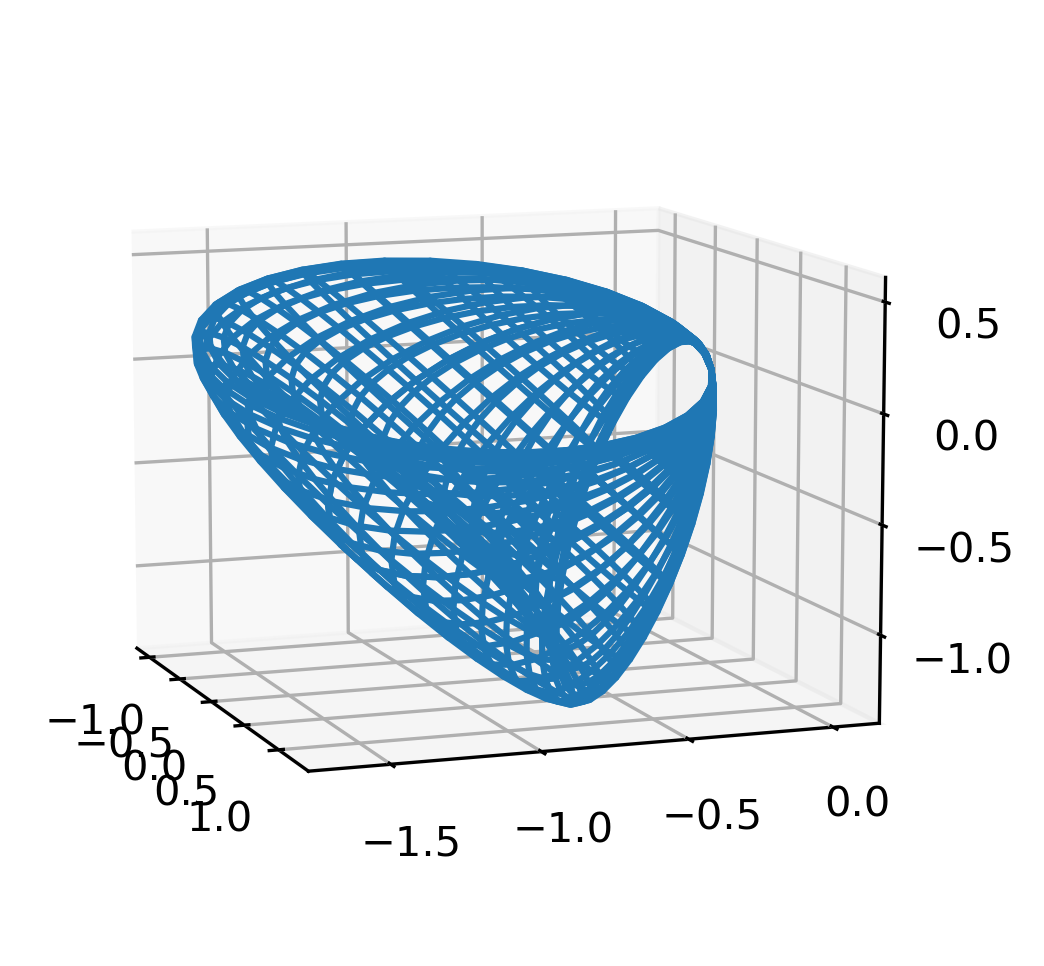

In [20]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

vis=model.visualize_shape()
ax.plot_wireframe(*vis.T)
ax.view_init(elev=10., azim=340)

In [ ]:

scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=140, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .12)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,zorder=3)    
    
   
   
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = model_obj.visualize_fieldline_dpsi(q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    

def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        #ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
        
def plot_shift(axis,extent,cx,cy,cz):
    #shift center of plot
    axis.set_xbound(cx-extent, cx+extent)
    axis.set_ybound(cy-extent, cy+extent)
    axis.set_zbound(cz-extent*0.75, cz+extent*0.75)  
    
  

## 2020 Jun 23 CME